## Data Cleaning Notebook

* Data used has been scraped from multiple health websites on the internet.
* A total of about 7 lakh questions and answers have been scraped.
* this notebook analyses and cleans the data.

In [2]:
import pandas as pd
import os
import ast
from tqdm import tqdm
tqdm.pandas()
import re
import unicodedata
%matplotlib inline

## Read data into a Data frame

In [3]:
DATA_DICT_LIST = []

def flatten_samples(x,category):
    try:
        al= set()
        question_dt = ast.literal_eval(x['question'])
        answer_list = ast.literal_eval(x['answers'])
        for answer in answer_list:
            if answer['answer'] not in al:
                al.add(answer['answer'])
                dt = {}
                dt['question'] = question_dt['question']
                dt['age'] = question_dt['age']
                dt['gender'] = question_dt['gender'][0].upper()
                dt['symptom_summary'] = question_dt['title']
                dt['doctor'] = answer['doctor']
                dt['speciality'] = answer['speciality']
                dt['answer'] = answer['answer']
                dt['category']  = category
                DATA_DICT_LIST.append(dt)
    except:
        return 'Fail'
    return 'Pass'


folder = r'C:\Users\sanjeet\Desktop\mycode\ai-doc-raw-data\raw_data\Answers_to_Scraped_questions_tsv_files'
files = os.listdir(folder)
for file in files:
    df = pd.read_csv(folder + '/'+ file,sep='\t')
    status = df.progress_apply((lambda x: flatten_samples(x,file.replace('.tsv',''))),axis = 1)
    print(status.value_counts())

  0%|                                                                                        | 0/12929 [00:00<?, ?it/s]

Pass    42644
Fail        3
dtype: int64


 20%|███████████████▌                                                             | 901/4474 [00:00<00:00, 9007.17it/s]

Pass    12927
Fail        2
dtype: int64


 10%|███████▉                                                                     | 895/8673 [00:00<00:00, 8864.37it/s]

Pass    4470
Fail       4
dtype: int64


100%|███████████████████████████████████████████████████████████████████████████| 8673/8673 [00:00<00:00, 11352.12it/s]


Pass    8670
Fail       3
dtype: int64


100%|█████████████████████████████████████████████████████████████████████████| 26224/26224 [00:02<00:00, 12510.46it/s]


Pass    26222
Fail        2
dtype: int64


100%|██████████████████████████████████████████████████████████████████████████| 22493/22493 [00:02<00:00, 8327.19it/s]


Pass    22486
Fail        7
dtype: int64


100%|█████████████████████████████████████████████████████████████████████████| 28690/28690 [00:02<00:00, 13204.37it/s]


Pass    28680
Fail       10
dtype: int64


100%|█████████████████████████████████████████████████████████████████████████| 18545/18545 [00:01<00:00, 11465.02it/s]


Pass    18527
Fail       18
dtype: int64


  0%|                                                                                        | 0/13766 [00:00<?, ?it/s]

Pass    42401
Fail       21
dtype: int64


 12%|█████████▏                                                                 | 1157/9497 [00:00<00:00, 11455.60it/s]

Pass    13765
Fail        1
dtype: int64


  0%|                                                                                        | 0/13731 [00:00<?, ?it/s]

Pass    9497
dtype: int64


100%|█████████████████████████████████████████████████████████████████████████| 13731/13731 [00:01<00:00, 13216.07it/s]


Pass    13715
Fail       16
dtype: int64


100%|█████████████████████████████████████████████████████████████████████████| 32320/32320 [00:02<00:00, 11567.64it/s]


Pass    32318
Fail        2
dtype: int64


  0%|                                                                                         | 0/8048 [00:00<?, ?it/s]

Pass    28312
Fail       32
dtype: int64
Pass    72
dtype: int64


100%|███████████████████████████████████████████████████████████████████████████| 8048/8048 [00:00<00:00, 11100.71it/s]


Pass    8041
Fail       7
dtype: int64


100%|███████████████████████████████████████████████████████████████████████| 122485/122485 [00:10<00:00, 12156.32it/s]


Pass    122468
Fail        17
dtype: int64


100%|█████████████████████████████████████████████████████████████████████████| 29625/29625 [00:02<00:00, 12724.66it/s]


Pass    29621
Fail        4
dtype: int64


100%|██████████████████████████████████████████████████████████████████████████| 13988/13988 [00:01<00:00, 8795.75it/s]

Pass    13968
Fail       20
dtype: int64


In [4]:
complete_data = pd.DataFrame(DATA_DICT_LIST)

## Add treatment category 
Based on the doctor's speciality we can add the type of treatment 
i.e. allopathy or non - allopathy (ayurveda, homeopathy, unani etc).
This can be used in the future to control the text generation output, as in the user can choose the type of treatment.


In [5]:
specialities = pd.Series(complete_data['speciality'].unique())
other_specialities = specialities[specialities.apply(lambda x: 'ayur' in x.lower() or 'alternat' in x.lower() or 'homoeo' in x.lower() or 'homeo' in x.lower() or 'unani' in x.lower() or 'internal' in x.lower() or 'naturo' in x.lower() or 'yoga' in x.lower())]
print(other_specialities)
complete_data['treatment_type'] = complete_data['speciality'].apply(lambda x: 'non-allopathy' if x in other_specialities.to_list() else 'allopathy')
print(complete_data['treatment_type'].value_counts())

24                                     Internal Medicine
35                                              Ayurveda
46                                  Alternative Medicine
51                                             homeopath
52                                            Homoeopath
71                                  Yoga and Naturopathy
81                                 Sexologist (Ayurveda)
165                            Ayurvedic Ophthalmologist
191                           Ayurvedic General Medicine
193                                    Electro Homeopath
232                                                Unani
266    Ayurvedic Endocrinologist & Internal Medicine ...
dtype: object
allopathy        700319
non-allopathy     13624
Name: treatment_type, dtype: int64


for this version let's only use the allopathy answers

In [6]:
complete_data =complete_data[complete_data['treatment_type']=='allopathy']
print(complete_data.shape)

(700319, 9)


## Cleaning the 'speciality' column

There are 295 Unique values in the speciality column upon analysing them I found that many of the specialities are repeated with different words for example ENT vs Otorhinolaryngologist.

In [7]:
specialities = pd.Series(complete_data['speciality'].unique())
print(specialities.shape)
specialities_map = {}

for spec  in specialities[specialities.apply(lambda x: 'psycho' in x.lower())] :
    if spec not in specialities_map:
        specialities_map[spec] = 'Psychologist'
for spec  in specialities[specialities.apply(lambda x: 'dermat' in x.lower() or 'tricho' in x.lower())]:
    if spec not in specialities_map:
        specialities_map[spec] = 'Dermatologist'
for spec in specialities[specialities.apply(lambda x: ('nutri' in x.lower() or 'diet' in x.lower()))]:
    if spec not in specialities_map:
        specialities_map[spec] = 'Dietitian/Nutritionist'
for spec in specialities[specialities.apply(lambda x: ('gynec' in x.lower() or 'obstetric' in x.lower()))]:
    if spec not in specialities_map:
        specialities_map[spec] = 'Gynecologist/Obstetrician'
for spec in specialities[specialities.apply(lambda x: ('opthal' in x.lower() or ('ophthal' in x.lower()) or ('eye' in x.lower())) )]:
    if spec not in specialities_map:
        specialities_map[spec] = 'Ophthalmologist/ Eye Surgeon'
for spec in specialities[specialities.apply(lambda x: ('dent' in x.lower() or 'orthodon' in x.lower() or 'prosthodon' in x.lower()))]:
    if spec not in specialities_map:
        specialities_map[spec] = 'Dentist'
for spec in specialities[specialities.apply(lambda x: (('ortho' in x.lower() or 'joint' in x.lower() or 'sport' in x.lower()) and 'nutri' not in x.lower() and 'psycho' not in x.lower()))]:
    if spec not in specialities_map:
        specialities_map[spec] = 'Orthopedist'
for spec in specialities[specialities.apply(lambda x: ('psychi' in x.lower()))]:
    if spec not in specialities_map:
        specialities_map[spec] = 'Psychiatrist'
for spec in specialities[specialities.apply(lambda x: ('cardi' in x.lower()))]:
    if spec not in specialities_map:
        specialities_map[spec] = 'Cardiologist'
for spec in specialities[specialities.apply(lambda x: ('pulmon' in x.lower()))]:
    if spec not in specialities_map:
        specialities_map[spec] = 'Pulmonologist'
for spec in specialities[specialities.apply(lambda x: ('Urol' in x))]:
    if spec not in specialities_map:
        specialities_map[spec] = 'Urologist'
for spec in specialities[specialities.apply(lambda x: ('gastro' in x.lower()))]:
    if spec not in specialities_map:
        specialities_map[spec] = 'Gastroenterologist'
for spec in specialities[specialities.apply(lambda x: ('physio' in x.lower()))]:
    if spec not in specialities_map:
        specialities_map[spec] = 'Physiotherapist'
for spec in specialities[specialities.apply(lambda x: ('onco' in x.lower()))]:
    if spec not in specialities_map:
        specialities_map[spec] = 'Oncologist'
for spec in specialities[specialities.apply(lambda x: ('ENT' in x) or ('otorhino' in x))]:
    if spec not in specialities_map:
        specialities_map[spec] = 'ENT/ Otorhinolaryngologist'
for spec in specialities[specialities.apply(lambda x: 'cosme' in x.lower() or 'aesthe' in x.lower() or 'plastic' in x.lower())]:
    if spec not in specialities_map:
        specialities_map[spec] = 'Cosmetologist/Plastic Surgeon'
for spec in specialities[specialities.apply(lambda x: ('rheuma' in x.lower()))]:
    if spec not in specialities_map:
        specialities_map[spec] = 'Orthopedist'      
for spec in specialities[specialities.apply(lambda x: ('infertility' in x.lower() or 'infertilty' in x.lower()))]:
    if spec not in specialities_map:
        specialities_map[spec] = 'Infertility Specialist'
for spec in specialities[specialities.apply(lambda x: ('endocri' in x.lower()))]:
    if spec not in specialities_map:
        specialities_map[spec] = 'Endocrinologist'     
for spec in specialities[specialities.apply(lambda x: ('neuro' in x.lower() and 'neuroto' not in x.lower()))]:
    if spec not in specialities_map:
        specialities_map[spec] = 'Neurologist'
for spec in specialities[specialities.apply(lambda x: ( ('nephro' in x.lower()) or ('kidney' in x.lower()) or ('renal' in x.lower())))]:
    if spec not in specialities_map:
        specialities_map[spec] = 'Nephrologist'
for spec in specialities[specialities.apply(lambda x: ( ('speech' in x.lower())))]:
    if spec not in specialities_map:
        specialities_map[spec] = 'Speech Therapist'
for spec in specialities[specialities.apply(lambda x: ( ('anesthesio' in x.lower())))]:
    if spec not in specialities_map:
        specialities_map[spec] = 'Anesthesiologist'
for spec in specialities[specialities.apply(lambda x: ('neuroto' in x.lower() and 'otolo' in x.lower()))]:
    if spec not in specialities_map:
        specialities_map[spec] = 'Otologist/ Neurotologist'
        
complete_data['cleaned_specialities'] = complete_data['speciality'].apply(lambda x: specialities_map[x] if x in specialities_map else x)



(283,)


In [8]:
specialities_map

{'Counselling Psychologist': 'Psychologist',
 'Psychotherapist': 'Psychologist',
 'Psychologist': 'Psychologist',
 'Clinical Psychologist': 'Psychologist',
 'Health Psychologist': 'Psychologist',
 'Educational Psychologist': 'Psychologist',
 'Neuropsychologist': 'Psychologist',
 'Family Psychologist': 'Psychologist',
 'Sports Psychologist': 'Psychologist',
 'Sexual Psychologist': 'Psychologist',
 'Dermatologist': 'Dermatologist',
 'Immunodermatologist': 'Dermatologist',
 'Trichologist': 'Dermatologist',
 'Dermatosurgeon': 'Dermatologist',
 'Aesthetic Dermatologist': 'Dermatologist',
 'Dermatologist/Cosmetologist': 'Dermatologist',
 'Dermatopathologist': 'Dermatologist',
 'Cosmetic Dermatovenereologist': 'Dermatologist',
 'Pediatric Dermatologist': 'Dermatologist',
 'Dermatovenereologist': 'Dermatologist',
 'Dietitian/Nutritionist': 'Dietitian/Nutritionist',
 'Pediatric Parenteral and Enteral Nutritionist': 'Dietitian/Nutritionist',
 'Clinical Nutritionist': 'Dietitian/Nutritionist',
 '

## Clean Answers

* Remove Doctor names
* Remove advertisements
* Remove Locations
* Take answers with only more than 10 words

In [9]:
# words_to_not_include = {'i','me','consult'}
# def is_not_include(x):
#     tok = [w.lower() for w in re.split(r'\s+',x)]
#     is_present = any([w in words_to_not_include for w in tok])
#     return is_present
# #complete_data['not_include'] = complete_data['answer'].apply(lambda x: is_not_include(x)  )

def remove_text_after(x):
    end = len(x)-1
    obj_search = re.search(r'\b((regard(s)?)|(thank(s)?)|(bye)|(share)|(online)|(upload)|(download)|(send)|(personally)|(practo)|(chat)|(i (a)?m)|(me)|(my)|(details)|(information)|(photos)|(dude)|(in person)|(consult private(ly)?)|(wishes)|(dr)|(direct(ly)? consult)|(mumbai)|(pune)|(allahabad)|(hyderabad)|(bangalore)|(bombay)|(consult direct(ly)?))\b',x.lower())
    if obj_search:
        end = obj_search.span()[0]
        while end > 0:
            if x[end] not in  ['.','\n']:
                end = end- 1
            else: 
                break
        x =  x[0:end]

    return x

def remove_urls(x):
    x = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%|\#|\!|\-)*\b', '', x, flags=re.MULTILINE)
    return x

def add_full_stop(x):
    # add missing full stop
    if len(x)>0:
        if x[-1] !='.':
            x = x + '.' 
    return x

def fix_all_caps(x):
    cap_count = 0
    x_s= re.sub(r'\s+','',x)
    if len(x_s)>0:
        for i in x_s: 
            if i.isupper():
                cap_count = cap_count + 1
        if cap_count/len(x_s) >= 0.9:
            x = x.lower()
    return x
    
def clean_answer(x):
    x = remove_text_after(x)
    x = remove_urls(x)
    x = add_full_stop(x)
    x = fix_all_caps(x)
    x = unicodedata.normalize("NFKD",x)
    x = re.sub(r'\s+',' ',x) 
    return x

def is_valid_answer(x):
    conds=[] 
    ## enough words
    conds.append(x['cleaned_answer_words'] >=10)
    ## not too many words
    conds.append(x['cleaned_answer_words'] <150)
    ## not a question
    if len(x) > 5:
        conds.append('?' not in x['cleaned_answer'][-5:])
    return all(conds)
    
    

In [10]:
complete_data['cleaned_answer'] = complete_data['answer'].progress_apply(lambda x: clean_answer(x))

100%|████████████████████████████████████████████████████████████████████████| 700319/700319 [01:11<00:00, 9734.74it/s]


In [11]:
complete_data['cleaned_answer_words'] = complete_data['cleaned_answer'].progress_apply(lambda x: len(re.split('\s+',x)))

100%|███████████████████████████████████████████████████████████████████████| 700319/700319 [00:07<00:00, 99223.41it/s]


In [12]:
complete_data['is_valid_answer'] = complete_data.progress_apply(lambda x: is_valid_answer(x),axis=1)

100%|███████████████████████████████████████████████████████████████████████| 700319/700319 [00:17<00:00, 39095.47it/s]


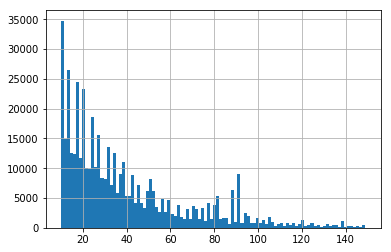

In [13]:
complete_data[complete_data['is_valid_answer']]['cleaned_answer_words'].hist(bins = 100)

## Clean questions

In [14]:
def is_valid_question(x):
    conds=[] 
    ## enough words
    conds.append(x['question_words'] >= 5)
    ## not too many words
    conds.append(x['question_words'] < 100)
    return all(conds)


In [15]:
complete_data['question_words'] = complete_data['question'].progress_apply(lambda x: len(re.split('\s+',x)))

100%|███████████████████████████████████████████████████████████████████████| 700319/700319 [00:09<00:00, 75642.10it/s]


In [16]:
complete_data['is_valid_question'] = complete_data.progress_apply(lambda x: is_valid_question(x),axis=1)

100%|███████████████████████████████████████████████████████████████████████| 700319/700319 [00:12<00:00, 54781.95it/s]


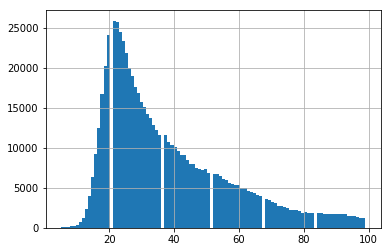

In [17]:
complete_data[complete_data['is_valid_question']]['question_words'].hist(bins=100 )

In [18]:
complete_data['is_valid_question'].value_counts()

True     671490
False     28829
Name: is_valid_question, dtype: int64

In [19]:
complete_data[(complete_data['is_valid_question']) & (complete_data['is_valid_answer'])].shape

(450428, 15)

## Clean Symptom Summary

In [20]:
def clean_symptom_summary(x):
    x = re.sub(r'\b((i)|(have)|(having)|(hv)|(am)|(my)|(had)|(how)|(who)|(whom))\b','',x,flags=re.IGNORECASE)
    return x

def is_valid_summary(x):
    conds=[] 
    ## not too many words
    conds.append(x['cleaned_symptom_summary_words'] <10)
    ## not a question
    if len(x) > 5:
        conds.append('?' not in x['cleaned_symptom_summary'][-5:])
    return all(conds)


# x = complete_data.sample(1).iloc[0]

# print(x['symptom_summary'])
# print(x['cleaned_symptom_summary'])
# print(x['question'])

In [21]:
complete_data['cleaned_symptom_summary'] = complete_data['symptom_summary'].progress_apply(lambda x: clean_symptom_summary(x))

100%|██████████████████████████████████████████████████████████████████████| 700319/700319 [00:03<00:00, 227376.43it/s]


In [22]:
complete_data['cleaned_symptom_summary_words'] = complete_data['cleaned_symptom_summary'].progress_apply(lambda x: len(re.split('\s+',x)))

100%|██████████████████████████████████████████████████████████████████████| 700319/700319 [00:02<00:00, 320618.77it/s]


In [23]:
complete_data['is_valid_symptom_summary'] = complete_data.progress_apply(lambda x: is_valid_summary(x),axis=1)

100%|███████████████████████████████████████████████████████████████████████| 700319/700319 [00:14<00:00, 48838.61it/s]


In [24]:
complete_data['is_valid_symptom_summary'].value_counts()

True     689709
False     10610
Name: is_valid_symptom_summary, dtype: int64

In [25]:
complete_data[(complete_data['is_valid_question']) & (complete_data['is_valid_answer']) & (complete_data['is_valid_symptom_summary'])].shape

(444313, 18)

## Analyse the Categories


In [26]:
categories = list(complete_data['category'][complete_data['is_valid_answer']].unique())

In [27]:
categories

['bone-muscle-problems',
 'brain-and-spine-problems',
 'cancer-care-and-treatment',
 'chest-breathing-problems',
 'child-health-issues',
 'diet-advice-and-tips',
 'ear-nose-throat-problems',
 'eye-care-problems',
 'flu',
 'heart-problems-remedies',
 'hormonal-imbalances',
 'kidney-problems',
 'mental-health',
 'pregnancy-and-infertility',
 'psychological-counselling',
 'sexual-health',
 'skin-hair-and-nail-problems',
 'stomach-problems-remedies',
 'tooth-and-mouth-problems']

In [28]:
for i in range(0,18):
    print('***'+categories[i]+'*****')
    fdf = complete_data[complete_data['category']==categories[i]]
    print(fdf['cleaned_specialities'].value_counts())
#     print(fdf['cleaned_specialities'].value_counts()[fdf['cleaned_specialities'].value_counts()>100].iloc[0:5])
#     specs = list(fdf['cleaned_specialities'].value_counts()[fdf['cleaned_specialities'].value_counts()>100].iloc[0:5].index)

***bone-muscle-problems*****
Orthopedist                                 39560
Physiotherapist                             12892
General Physician                           11941
Spine Surgeon                                1752
Hand Surgeon                                  445
Spine and Pain Specialist                     419
Occupational Therapist                        390
Spine And Pain Specialist                     241
Neurologist                                   211
Pain Management Specialist                    146
Consultant Physician                          146
Family and Community Medicine Specialist      113
Cardiologist                                   99
General Practitioner                           89
Rehab & Physical Medicine Specialist           45
Geriatric OT                                   33
Acupuncturist                                  24
Medical Microbiologist                         23
Chiropractor                                   19
Diabetologist        

ENT/ Otorhinolaryngologist                  24681
General Physician                            4139
Otologist/ Neurotologist                     1275
Allergist/Immunologist                       1244
Speech Therapist                              569
Rhinologist                                   270
Head and Neck Surgeon                         264
Audiologist                                   234
Family and Community Medicine Specialist       91
Pediatric Otorhinolaryngologist                86
Consultant Physician                           11
Oncologist                                     10
General Practitioner                            7
Dentist                                         6
Medical Microbiologist                          5
Diabetologist                                   4
Pulmonologist                                   3
Otolaryngic Allergist and Immunologist          3
Cosmetologist/Plastic Surgeon                   3
Family Physician                                3


Psychologist         570
Psychiatrist          10
Hypnotherapist         5
General Physician      3
Name: cleaned_specialities, dtype: int64
***sexual-health*****
Sexologist                                   6385
Gynecologist/Obstetrician                    1831
General Physician                            1660
Infertility Specialist                        553
Urologist                                     440
Andrologist                                   431
Psychiatrist                                  362
Dermatologist                                 336
ENT/ Otorhinolaryngologist                    160
Venereologist                                 122
Hair Transplant Surgeon                        99
HIV Specialist                                 82
Sexual and Reproductive Health Specialist      78
Family and Community Medicine Specialist       55
Endocrinologist                                26
General Surgeon                                21
Nephrologist                         

### Create the text - to - text model input 

#### Input Tags :
* a_t : age
* g_t : gender
* q_t : question 

#### Output Tags :
* cat_t : Category 
* spc_t : Speciality
* sym_t : Symptom Summary
* ans_t : Doctor's Reply

#### Example :
* Input Example :  "a_t 24 g_t F q_t My aunt's 4 or 5 bone of spinal cord has increased. So how it will medicate or any surgery required please help with this"

* Output Example: "cat_t bone-muscle-problems spc_t Family Physician sym_t Spinal cord bone increase ans_t Need to have a complete history, with your history it doesn't look that serious but can proceed to weakness of lower limbs if not treated properly."

In [29]:
def clean_text(text):
    text=text.replace('\'',' ')
    text=text.replace('\"',' ')
    text = text.replace('\t', ' ')
    text = text.replace('\r', ' ')
    text = text.replace('\n', ' ')
    text=text.replace('  ',' ')
    text=text.strip()
    return text

In [30]:
filtered_data = complete_data[((complete_data['is_valid_answer']) & (complete_data['is_valid_question']) & (complete_data['is_valid_symptom_summary']))]
print(filtered_data.shape)

(444313, 18)


In [31]:
def create_text_to_text_input(x):
    question = 'a_t '+str(x['age'])+' g_t '+x['gender']+' q_t '+x['question'] 
    question = clean_text(question)
    return question

def create_text_to_text_output(x):
    answer = 'cat_t ' + x['category'] + ' spc_t '+ x['cleaned_specialities'] + ' sym_t ' + x['cleaned_symptom_summary'] + ' ans_t '+ x['cleaned_answer']
    answer = clean_text(answer)
    return answer

In [32]:
filtered_data['input_text'] = filtered_data.progress_apply((lambda x: create_text_to_text_input(x)),axis=1 )
filtered_data['output_text'] = filtered_data.progress_apply((lambda x: create_text_to_text_output(x)),axis=1 )

100%|███████████████████████████████████████████████████████████████████████| 444313/444313 [00:11<00:00, 40014.40it/s]
C:\Users\sanjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
100%|███████████████████████████████████████████████████████████████████████| 444313/444313 [00:13<00:00, 31908.55it/s]
C:\Users\sanjeet\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [33]:
import random
random.seed(0)
file_name='data_v3.tsv'
filtered_data = filtered_data.sample(frac=1)

In [34]:
filtered_data.shape

(444313, 20)

In [35]:
train_out_df = filtered_data[['input_text','output_text']].iloc[0:-100]
test_out_df = filtered_data[['input_text','output_text']].iloc[-100:]
train_out_df.to_csv('train'+file_name,sep='\t',index=None,header=False)
test_out_df.to_csv('test'+file_name,sep='\t',index=None,header=False)
train_out_df.sample(250).to_csv('dev'+file_name,sep='\t',index=None,header=False)

print('Train Size')
print(train_out_df.shape)
print('Test Size')
print(test_out_df.shape)

Train Size
(444213, 2)
Test Size
(100, 2)
